In [92]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb

In [93]:
DATA_DIR = '/home/jupyter/DREAM'
df = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
print(df.shape)
df.head()

(138, 13)


,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,dist2charge,label
0,0,0,0,31313.811557,27515.9650,30114.676,2.837071,2.049820,0.110429,0.228488,1.094444,0.0,0
1,1,1,1,22119.663201,2722.9253,NaN,3.355176,NaN,0.165529,NaN,NaN,0.0,1
2,2,2,3,7815.112261,7369.4688,6288.264,2.286271,2.166214,0.086934,0.104079,0.853286,NaN,2
3,2,3,3,2634.673219,2338.2720,2582.522,1.868708,1.387169,0.185439,0.253425,1.104457,NaN,2
4,4,6,2,27610.212415,14253.6210,11683.265,8.165252,4.762796,0.049337,0.059803,0.819670,0.0,3


In [94]:
# train test split by eventId!
id_train, id_test = train_test_split(df.eventId.values,
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify=df.PrimaryDecayMode.values)
print(id_train.shape, id_test.shape)

(96,) (42,)


In [95]:
excl_columns = ['PrimaryDecayMode', 'clusterId', 'VecShowerEnergy', 'label']

# train dataset
df_train = df[df.eventId.isin(id_train)].drop(['eventId'], axis=1)
y_train = df_train.label.values
z_train = df_train.VecShowerEnergy.values
df_train.drop(excl_columns, inplace=True, axis=1)
X_train = df_train.values
train_data_y = lgb.Dataset(X_train, label=y_train, feature_name=list(df_train.columns.values))
train_data_z = lgb.Dataset(X_train, label=z_train, feature_name=list(df_train.columns.values))

# test data set
df_test = df[df.eventId.isin(id_test)].drop(['eventId'], axis=1)
y_test = df_test.label.values
z_test = df_test.VecShowerEnergy.values
id_test = df_test.clusterId.values.reshape([-1,1])
df_test.drop(excl_columns, inplace=True, axis=1)
X_test = df_test.values
test_data_y = lgb.Dataset(X_test, label=y_test, feature_name=list(df_test.columns.values))
test_data_z = lgb.Dataset(X_test, label=z_test, feature_name=list(df_test.columns.values))

### Plot features

In [96]:
# xtitle = df_train.columns
# fig, ax = plt.subplots(4, 2, figsize=(8,12))
# for i in range(X_train.shape[1]):
#     for j in np.unique(y_train):
#         h = ax[i//2][i%2].hist(X_train[:,i][y_train==j], histtype='step')
#         ax[i//2][i%2].set_xlabel(xtitle[i])
#         ax[i//2][i%2].set_ylabel(f"Events") # / {binwidth}")

# Classification

(Boosted) decision trees 'unaffected' by feature scaling

### Training

In [97]:
params = {
    'num_class': [4],
    'objective': ['multiclass', 'multiclassova'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1],  # default = 0.1
    'num_leaves': [31],  # default = 31
    'metric': ['multi_logloss']
}

In [98]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [99]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_y, num_boost_round=500, early_stopping_rounds=20, seed=42)
    results += [(i, len(cv_results['multi_logloss-mean']), cv_results['multi_logloss-mean'][-1])]

In [100]:
results.sort(key=lambda x: x[2])
results

[(0, 54, 0.278652466021973), (1, 42, 0.3285066774823741)]

In [101]:
bst = lgb.train(param[results[0][0]], train_data_y, num_boost_round=results[0][1])

### Testing

In [102]:
y_pred = np.argmax(bst.predict(X_test), axis=1).reshape([-1,1])

In [103]:
confusion_matrix(y_test, y_pred)

array([[ 7,  0,  0,  0],
       [ 2,  1,  0,  0],
       [ 0,  0, 57,  0],
       [ 0,  0,  0, 15]])

In [104]:
accuracy_score(y_test, y_pred)

0.975609756097561

In [105]:
df_new = pd.DataFrame(np.hstack((id_test, y_pred)), columns=['clusterId', 'predictedLabel'])
df_merged = df.merge(df_new, how='inner', on='clusterId')
df_merged.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,dist2charge,label,predictedLabel
0,2,2,3,7815.112261,7369.4688,6288.2640,2.286271,2.166214,0.086934,0.104079,0.853286,NaN,2,2
1,2,3,3,2634.673219,2338.2720,2582.5220,1.868708,1.387169,0.185439,0.253425,1.104457,NaN,2,2
2,8,10,3,4539.675005,3622.3496,3705.7480,2.103034,1.730188,0.121583,0.128878,1.023023,32.063404,2,2
3,8,11,3,6965.990793,6242.2130,6226.3640,2.888289,2.033888,0.117345,0.136364,0.997461,45.605458,2,2
4,8,12,3,30670.818780,9066.4860,7068.8994,5.988606,5.210439,0.058056,0.075069,0.779674,0.000000,3,3


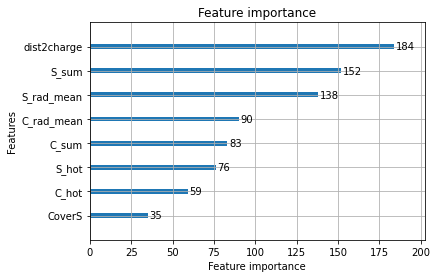

In [106]:
lgb.plot_importance(bst)

In [110]:
param[results[0][0]]

{'num_class': 4,
 'objective': 'multiclass',
 'boosting': 'gbrt',
 'learning_rate': 0.1,
 'num_leaves': 31,
 'metric': 'multi_logloss'}

In [122]:
from sklearn.inspection import permutation_importance
model = lgb.LGBMClassifier(**param[results[0][0]], n_estimators=results[0][1])
model = model.fit(X_train, y_train)
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train_data_y.feature_name[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

dist2charge0.416 +/- 0.045
C_hot   0.039 +/- 0.019
S_sum   0.028 +/- 0.014


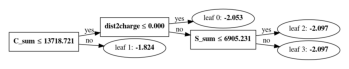

In [54]:
lgb.plot_tree(bst)

## Regression

### Training

In [123]:
params = {
    'objective': ['regression'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1],  # default = 0.1
    'num_leaves': [31],  # default = 31
    'metric': ['mape']
}

In [124]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [125]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_z, num_boost_round=500, early_stopping_rounds=20, seed=42, stratified=False)
    results += [(i, len(cv_results['mape-mean']), cv_results['mape-mean'][-1])]

In [126]:
results.sort(key=lambda x: x[2])
results

[(0, 39, 0.5309867197371606)]

In [127]:
bst = lgb.train(param[results[0][0]], train_data_z, num_boost_round=results[0][1])

### Testing

In [128]:
z_pred = bst.predict(X_test).reshape([-1,1])

In [129]:
np.mean(np.abs((z_test - z_pred) / z_test))

1.8627897669165951

In [130]:
from sklearn.metrics import median_absolute_error
median_absolute_error(z_test, z_pred)

1257.8126030555213

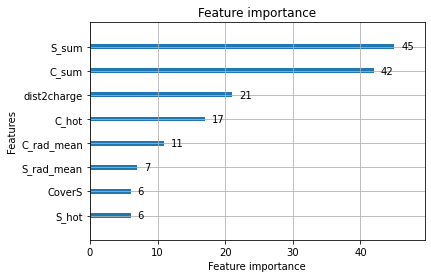

In [131]:
lgb.plot_importance(bst)

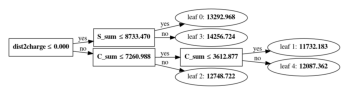

In [132]:
lgb.plot_tree(bst)

## Decay classification

In [80]:
def decayClassification(x):
    counts = x.predictedLabel.value_counts()
    mode = np.nan
    if 1 in counts.keys():
        mode = 1
    elif 2 in counts.keys():
        mode = 2
    elif 4 in counts.keys():
        mode = 3
        if 3 in counts.keys():
            if counts[3] == 2:
                mode = 4
            elif counts[3] == 4:
                mode = 5
    x['predictedPrimaryDecayMode'] = mode
    return x

In [81]:
df_merged = df_merged.groupby('eventId').apply(decayClassification)

In [82]:
confusion_matrix = pd.crosstab(df_merged.PrimaryDecayMode, df_merged.predictedPrimaryDecayMode, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  1.0  2.0
Actual             
1            1    0
3            0   27
4            0   42
